In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, special
from scipy.interpolate import splrep, splev
from scipy.special import comb, factorial2
from scipy.stats import norm
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   # imp vol estimator based on P Jäckel Let's be rational
import math
import numpy as np
from scipy.stats import norm
from scipy.special import factorial2
from py_vollib.black_scholes.implied_volatility import implied_volatility
from scipy.interpolate import interp1d
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, factorial2
import scipy.special
import warnings
from py_vollib.black.implied_volatility import implied_volatility as bs_iv
from py_vollib.black_scholes.implied_volatility import implied_volatility

np.random.seed(42)

In [3]:
# === Sigma squared for G_s^t ===
def sigma_squared_G(t, s, theta, lambda_x, lambda_y):
    dt = s - t  # assumes s > t
    term1 = (theta**2 / (2 * lambda_x)) * (1 - np.exp(-2 * lambda_x * dt))
    term2 = ((1 - theta)**2 / (2 * lambda_y)) * (1 - np.exp(-2 * lambda_y * dt))
    term3 = (2 * theta * (1 - theta) / (lambda_x + lambda_y)) * (1 - np.exp(-(lambda_x + lambda_y) * dt))
    return term1 + term2 + term3

# === Horner's method for vectorized polynomial evaluation ===
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

# === Black-Scholes call price ===
def bs_price_call(S, sigma, T, K):
    S = np.asarray(S)
    sigma = np.asarray(sigma)
    K = np.asarray(K)

    with np.errstate(divide='ignore', invalid='ignore'):
        d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call = S * norm.cdf(d1) - K * norm.cdf(d2)
    return np.nan_to_num(call)

# === Forward variance curve interpolator ===
def make_fv_curve_interpolator(T_array, fv_array):
    return interp1d(T_array, fv_array, kind='cubic', fill_value='extrapolate')

# === Gaussian moment calculation ===
def moment_gaussian(degree, sigma):
    if degree % 2 == 0:
        return sigma ** degree * factorial2(degree - 1)
    else:
        return 0.0

# === Compute covariance matrix for OU processes ===
def compute_sigma_matrix(lambda_x, lambda_y, T):
    var_X = (1 - np.exp(-2 * lambda_x * T)) / (2 * lambda_x)
    var_Y = (1 - np.exp(-2 * lambda_y * T)) / (2 * lambda_y)
    cov_XY = (1 - np.exp(-(lambda_x + lambda_y) * T)) / (lambda_x + lambda_y)
    return np.array([[var_X, cov_XY], [cov_XY, var_Y]])

# === Function h_2 used in quantization integration ===
def h_2(x, y, beta, delta, n):
    result = 0.0
    for m in range(n):
        for l in range(m, n):
            result += beta[m, l] * x ** m * y ** (l - m)
    return result / delta

# === Quantization data loading with fallback ===
try:
    data = np.loadtxt("/home/hassene/Desktop/Stage_code/mult_dimensional_grids/1450_2_nopti")
    points = data[:-1, 1:3]
    weights = data[:-1, 0]
except FileNotFoundError:
    print("Quantization file not found, using default data.")
    points = np.random.randn(100, 2)
    weights = np.ones(100) / 100

# === Gaussian expectation using quantization grids ===
def gaussian_expectation(f, mu, Sigma, points=points, weights=weights):
    A = np.linalg.cholesky(Sigma + 1e-5 * np.eye(2))
    transformed_points = points @ A.T + mu
    f_vals = np.array([f(x, y) for x, y in transformed_points])
    return np.sum(f_vals * weights)



def compute_expected_fx2_analytical(a_k, theta, lambda_x, lambda_y, t_grid):
    """
    Computes E[f^2(X_t)] analytically under Gaussian assumption with correct covariance term.
    """

    n = len(a_k)
    cauchy_product = np.convolve(a_k, a_k)

    # Correct variance formula WITH cross-term
    var_X = (
        theta ** 2 / (2 * lambda_x) * (1 - np.exp(-2 * lambda_x * t_grid))
        + (1 - theta) ** 2 / (2 * lambda_y) * (1 - np.exp(-2 * lambda_y * t_grid))
        + 2 * theta * (1 - theta) / (lambda_x + lambda_y) * (1 - np.exp(-(lambda_x + lambda_y) * t_grid))
    )
    std_X = np.sqrt(var_X)

    p_even = np.arange(0, 2 * n, 2)  # even exponents
    coeffs = cauchy_product[p_even].reshape(-1, 1)
    std_powers = std_X ** p_even.reshape(-1, 1)
    moments = scipy.special.factorial2(p_even - 1).reshape(-1, 1)
    moments[p_even.reshape(-1, 1) == 0] = 1  # (0-1)!! = 1

    expected_fx2 = np.sum(coeffs * std_powers * moments, axis=0)
    expected_fx2 = np.maximum(expected_fx2, 1e-12)
    return expected_fx2

In [4]:
a_k = np.array([ 2.0,1])
theta = 0.5
lambda_x = 1.0
lambda_y = 2.0
t_grid = np.array([0.5])

val = compute_expected_fx2_analytical(a_k, theta, lambda_x, lambda_y, t_grid)
print(val)


[4.26253492]


In [5]:
import scipy.special
class two_Quintic_OU():
    def __init__(self, theta, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage, S0):
        self.theta = theta
        self.rho = rho
        self.a_k = a_k
        self.lambda_x = lambda_x
        self.lambda_y = lambda_y
        self.N_sims = N_sims
        self.n_steps = n_steps
        self.T = T
        self.S0 = S0
        self.X1 = None
        self.X2 = None
        self.Z = None 
        self.sigma_t = None
        if Y_storage is None:
            Y_storage = np.random.normal(0, 1, (N_sims, n_steps))
            Y_storage[:, 0] = 0  # Enforce W_0 = 0
            self.Y_storage = Y_storage
        else:
            self.Y_storage = Y_storage


    def simulate_ou(self, x1, x2):
        dt = self.T / self.n_steps
        X1 = np.zeros((self.N_sims, self.n_steps + 1))
        X2 = np.zeros((self.N_sims, self.n_steps + 1))
        exp1 = np.exp(-self.lambda_x * dt)
        exp2 = np.exp(-self.lambda_y * dt)
        var1 = np.sqrt((1 - np.exp(-2 * self.lambda_x * dt)) / (2 * self.lambda_x))
        var2 = np.sqrt((1 - np.exp(-2 * self.lambda_y * dt)) / (2 * self.lambda_y))
        X1[:, 0] = x1
        X2[:, 0] = x2

        for i in range(self.n_steps):
            X1[:, i + 1] = exp1 * X1[:, i] + var1 * self.Y_storage[:, i]
            X2[:, i + 1] = exp2 * X2[:, i] + var2 * self.Y_storage[:, i]

        self.X1 = X1
        self.X2 = X2
        return X1, X2



    def simulate_OU(self, x1=0, x2=0):
        self.simulate_ou(x1, x2)
        self.Z = self.theta * self.X1 + (1 - self.theta) * self.X2
        return self.Z

    def sigma(self, ksi_0_func,x1=0,x2=0):
        
        self.simulate_OU(x1=x1, x2=x2)
        poly_vals = horner_vector(self.a_k[::-1], self.Z)
        f_Z_squared = poly_vals ** 2
        expected_fx2_mc = np.mean(f_Z_squared, axis=0) + 1e-10
        t_grid = np.linspace(0, self.T, self.n_steps + 1)
        expected_fx2 = compute_expected_fx2_analytical(self.a_k, self.theta, self.lambda_x, self.lambda_y, t_grid)
        #print("this value should be 1 ,",np.min(expected_fx2_mc/expected_fx2))
        #print("this value should be 1 ,",np.max(expected_fx2_mc/expected_fx2))
        #print('this value shoud be 1 ',np.mean((expected_fx2_mc/expected_fx2)) )
        ksi_vals = ksi_0_func(t_grid)
        scaling = (ksi_vals / expected_fx2)[None, :]  
        sigma_squared =  scaling   
        self.sigma_t = poly_vals * np.sqrt(sigma_squared)
        return self.sigma_t

    def simulate_logS_batched(self):
        dt = self.T / self.n_steps
        log_S = np.zeros((self.N_sims, self.n_steps + 1))
        log_S[:, 0] = np.log(self.S0)
        for i in range(1, self.n_steps + 1):
            sigma_prev = self.sigma_t[:, i - 1]
            drift = -0.5 * (self.rho * sigma_prev) ** 2 * dt
            diffusion = self.rho * sigma_prev * np.sqrt(dt) * self.Y_storage[:, i - 1]
            log_S[:, i] = log_S[:, i - 1] + drift + diffusion
        self.log_S = log_S
        return log_S
    def price_call_conditional_mc(self, ksi_0, strikes, x1=0,x2=0,compute=True):
        if (self.sigma_t is None):
            self.sigma(ksi_0, x1=x1,x2=x2)
        log_S = self.simulate_logS_batched()
        ST = np.exp(log_S[:, -1])
        int_var = np.sum(self.sigma_t[:, :-1] ** 2 * (self.T / self.n_steps), axis=1)
        Q = max(int_var) + 1e-10 ; 
        vol_residual_X = np.sqrt((1 - self.rho ** 2) * int_var / self.T)
        vol_residual_Y = abs(self.rho) *np.sqrt(Q-int_var)
        X = np.zeros((self.N_sims, len(strikes)))
        Y = np.zeros((self.N_sims, len(strikes)))
        for j, K in enumerate(strikes):
            X[:, j] = bs_price_call(ST, vol_residual_X, self.T, K)
            Y[:, j] = bs_price_call(ST, vol_residual_Y, self.T, K)   
        if (compute):
            prices = X
            return np.mean(prices, axis=0), np.std(prices, axis=0)
        eY = np.mean(Y, axis=0)
        var_Y = np.var(Y, axis=0)
        cov_X_Y = np.mean(X * Y, axis=0) - eY * np.mean(X, axis=0)
        c = cov_X_Y / (var_Y )
        prices = X + c * (eY - Y)
        print("np std is ",np.std(prices, axis=0))
        return np.mean(prices, axis=0), np.std(prices, axis=0)
    def run_pipeline(self, ksi_0_func, flag='c', x1=0, x2=0, strike_array=None):
        lm = np.linspace(-0.5, 0.1, 50)
        if strike_array is None:
            strike_array = self.S0 * np.exp(lm)

        mean_prices, std_prices = self.price_call_conditional_mc(ksi_0_func, strike_array, x1=x1, x2=x2)
        print("Mean prices:", mean_prices)

        intrinsic_values = np.maximum(self.S0 - strike_array, 0)
        eps = 1e-6

        # Ensure prices are above intrinsic for safe implied volatility calculation
        safe_prices = np.where(
            mean_prices > intrinsic_values + eps,
            mean_prices,
            intrinsic_values + eps
        )

        # Vectorized implied volatility with error handling
        def safe_implied_vol(price, S, K, T, flag, r):
            try:
                return implied_volatility(price, S, K, T, r, flag)
            except:
                return np.nan

        # Use a safe vectorizer instead of raw vec_find_vol_rat
        vec_safe_iv = np.vectorize(safe_implied_vol)

        imp_vols = vec_safe_iv(safe_prices, self.S0, strike_array, self.T, flag, 0)

        # Filter out NaNs from invalid vols
        valid = ~np.isnan(imp_vols)

        return strike_array[valid], imp_vols[valid]



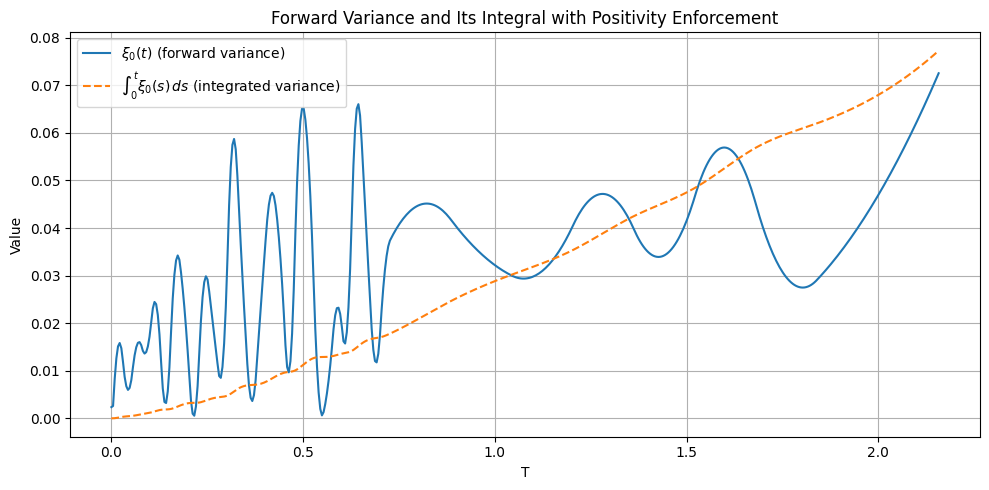

All values of ksi_0 positive? True
Min value of ksi_0: 0.0005527191774264942
ksi(0) = :0.002362937779691221
Mean prices: [3.94026949e+01 3.86565174e+01 3.79012105e+01 3.71366684e+01
 3.63627851e+01 3.55794538e+01 3.47865676e+01 3.39840195e+01
 3.31717024e+01 3.23495095e+01 3.15173342e+01 3.06750708e+01
 2.98226147e+01 2.89598625e+01 2.80867129e+01 2.72030670e+01
 2.63088292e+01 2.54039082e+01 2.44882176e+01 2.35616779e+01
 2.26242181e+01 2.16757782e+01 2.07163124e+01 1.97457933e+01
 1.87642178e+01 1.77716141e+01 1.67680526e+01 1.57536583e+01
 1.47286295e+01 1.36932630e+01 1.26479905e+01 1.15934325e+01
 1.05304807e+01 9.46042462e+00 8.38515158e+00 7.30747242e+00
 6.23167101e+00 5.16446646e+00 4.11673311e+00 3.10654812e+00
 2.16414832e+00 1.33793318e+00 6.94389292e-01 2.90269726e-01
 1.05869709e-01 4.15972401e-02 1.94330263e-02 1.03998173e-02
 6.07503611e-03 3.76631643e-03]


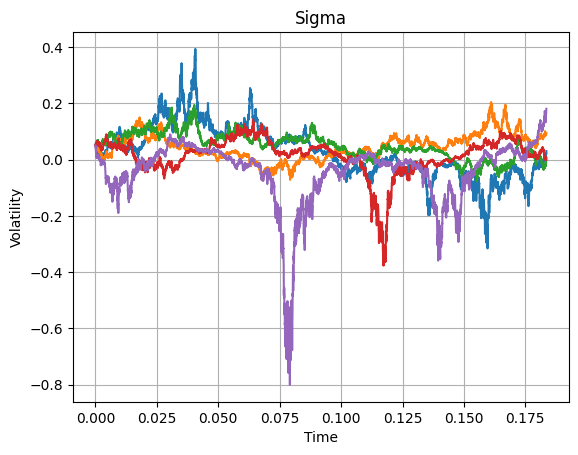

sigma 0 is  0.048610058420981365


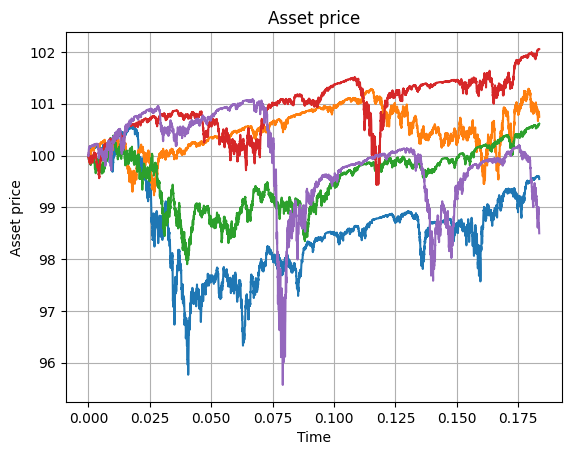

(8000, 8001)
avg value of S_T is  99.99949647691034
var value of S_T is  0.0031783584482010904


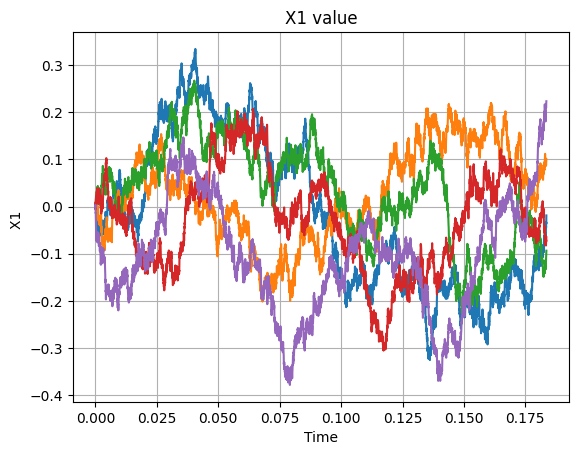

(8000, 8001)
avg value of X is  1.0002501700093436
var value of X is  0.00022760855595824176


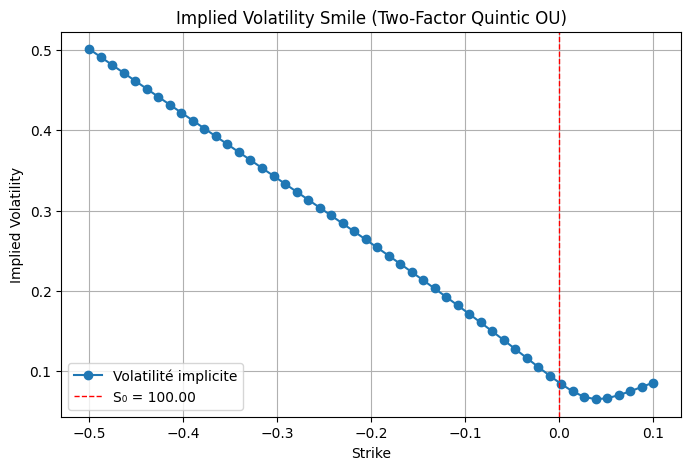

In [6]:
T = 67/365
n_steps = 8000
N_sims = 8000
a_k = [0.0004, 0.0046, 0, 0.0096, 0, 1]
lambda_x = 31.8
lambda_y = 0.659
S0 = 100
rho = -0.765
theta = 0.964
# === Données ===
T_nodes = np.array([
    0.0001, 0.0005, 0.001 , 0.0015, 0.0055, 0.0303, 0.0552, 0.0801,
    0.105 , 0.1298, 0.1547, 0.1796, 0.2044, 0.2293, 0.2542, 0.2791,
    0.3039, 0.3288, 0.3537, 0.3785, 0.4034, 0.4283, 0.4531, 0.478 ,
    0.5029, 0.5278, 0.5526, 0.5775, 0.6024, 0.6272, 0.6521, 0.677 ,
    0.7019, 0.7267, 0.8857, 1.0447, 1.2036, 1.3626, 1.5216, 1.6805,
    1.8395, 1.9985, 2.1574
])

int_var_nodes = np.array([
    0.00000023, 0.00000117, 0.00000235, 0.00000352, 0.00001286,
    0.00033119, 0.00052188, 0.00088383, 0.00126912, 0.0017979 ,
    0.00196599, 0.00270324, 0.00322654, 0.00332477, 0.00396569,
    0.00442826, 0.0048271 , 0.00615094, 0.00692078, 0.00707639,
    0.0076925 , 0.00881826, 0.00963305, 0.01002174, 0.01142226,
    0.01267608, 0.012891  , 0.013082  , 0.01361588, 0.0141797 ,
    0.01568081, 0.01668033, 0.01704239, 0.01780291, 0.02466145,
    0.03022112, 0.03537132, 0.04249715, 0.04841705, 0.05687464,
    0.0619833 , 0.06789834, 0.07726454
])

#
# === Création de la spline cubique pour approximer la variance intégrée ===
spline_int_var = interpolate.splrep(T_nodes, int_var_nodes, k=3)

# === Fonction ksi_0 calculant la variance instantanée par dérivation avec positivité assurée ===
def ksi_0(t):
    deriv_values = interpolate.splev(t, spline_int_var, der=1)
    # Assure positivity:
    return np.sqrt(deriv_values ** 2)

# === Fonction pour calculer l'intégrale de ksi_0 ===
def integral_ksi_0(t):
    return interpolate.splev(t, spline_int_var, der=0)

# === Grille pour tracé ===
t_grid = np.linspace(T_nodes[0], T_nodes[-1], 500)
ksi_values = ksi_0(t_grid)
int_ksi_values = integral_ksi_0(t_grid)

# === Tracé ===
plt.figure(figsize=(10, 5))

plt.plot(t_grid, ksi_values, label=r'$\xi_0(t)$ (forward variance)')
plt.plot(t_grid, int_ksi_values, label=r'$\int_0^t \xi_0(s)\,ds$ (integrated variance)', linestyle='--')

plt.xlabel('T')
plt.ylabel('Value')
plt.title('Forward Variance and Its Integral with Positivity Enforcement')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Vérification positivité
print(f"All values of ksi_0 positive? {np.all(ksi_values >= 0)}")
print(f"Min value of ksi_0: {np.min(ksi_values)}")
print(f"ksi(0) = :{ksi_0(0)}")

Y_storage = np.random.normal(0, 1, (N_sims, n_steps))
#Y_storage[:, 0] = 0 
# ==== SIMULATION ET SMILE ====
model = two_Quintic_OU(theta, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage=Y_storage, S0=S0)
strikes, iv_smile = model.run_pipeline(ksi_0)


# Affichage de sigma (volatilité locale)
X0 = np.linspace(0, T, n_steps + 1)

for i in range(5):
    sigma = model.sigma_t[i, :]  # une trajectoire
    plt.plot(X0, sigma)
plt.title("Sigma")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()
print("sigma 0 is ",model.sigma_t[0,0])

for i in range(5):
    S_T = np.exp(model.log_S)[i,:]
    plt.plot(X0,S_T)

plt.title("Asset price")
plt.xlabel("Time")
plt.ylabel("Asset price")
plt.grid(True)
plt.show()
print(model.log_S.shape)
ST = np.exp(model.log_S[:,10])
print("avg value of S_T is ",np.mean(ST))
print("var value of S_T is ", np.var(ST))
for i in range(5):
    X = model.X1[i,:]
    plt.plot(X0,X)
plt.title("X1 value")
plt.xlabel("Time")
plt.ylabel("X1 ")
plt.grid(True)
plt.show()
print(model.X1.shape)
X = np.exp(model.X1[:,10])
print("avg value of X is ",np.mean(X))
print("var value of X is ", np.var(X))

# ==== PLOT Smile ====
plt.figure(figsize=(8, 5))
plt.plot(np.log(strikes/S0), iv_smile, marker='o', label="Volatilité implicite")

# Ligne verticale à S0
plt.axvline(x=0, color='r', linestyle='--', linewidth=1, label=f"S₀ = {model.S0:.2f}")
plt.title("Implied Volatility Smile (Two-Factor Quintic OU)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.legend()

plt.show()

#refaire avec ksi 0 constant pour tester le SSR


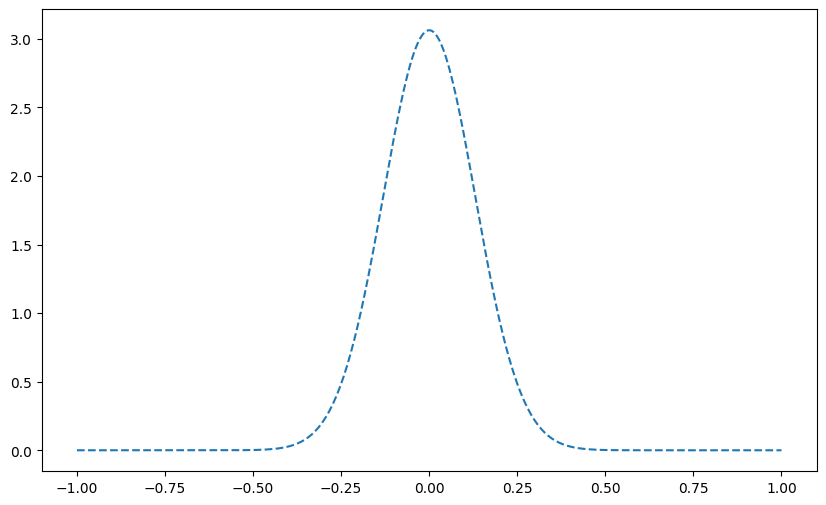

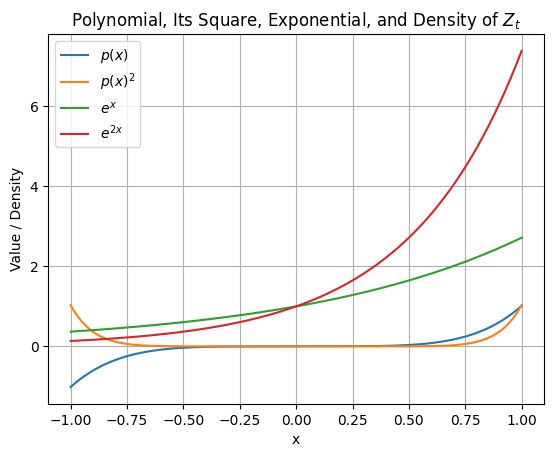

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_poly_and_exp_with_density(a_k, theta, lambda_x, lambda_y, T, x_min=-1, x_max=1, n_points=400):
    """
    Plots:
    - polynomial p(x)
    - p(x)^2
    - exp(x)
    - density of Z_t = theta X_t + (1-theta) Y_t
    """

    x = np.linspace(x_min, x_max, n_points)

    # Polynomial and its square
    p_x = np.polyval(a_k[::-1], x)
    p_x_squared = p_x ** 2

    # Exponential
    exp_x = np.exp(x)

    # Compute Var(Z_t)
    var_X = (1 - np.exp(-2 * lambda_x * T)) / (2 * lambda_x)
    var_Y = (1 - np.exp(-2 * lambda_y * T)) / (2 * lambda_y)
    cov_XY = (1 - np.exp(-(lambda_x + lambda_y) * T)) / (lambda_x + lambda_y)
    var_Z = theta**2 * var_X + (1 - theta)**2 * var_Y + 2 * theta * (1 - theta) * cov_XY
    std_Z = np.sqrt(var_Z)

    # Density
    density = norm.pdf(x, loc=0, scale=std_Z)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, density, label=fr"$\mathcal{{N}}(0, {var_Z:.4e})$", linestyle='--')
    plt.show()
    plt.plot(x, p_x, label=r'$p(x)$')
    plt.plot(x, p_x_squared, label=r'$p(x)^2$')
    plt.plot(x, exp_x, label=r'$e^{x}$')
    plt.plot(x, exp_x**2,label = '$e^{2x}$')
    plt.title(r"Polynomial, Its Square, Exponential, and Density of $Z_t$")
    plt.xlabel("x")
    plt.ylabel("Value / Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
T = 67/365
a_k = [0.0004, 0.0046, 0, 0.0096, 0, 1]
lambda_x = 31.8
lambda_y = 0.659
S0 = 100
theta = 0.964

plot_poly_and_exp_with_density(a_k, theta, lambda_x, lambda_y, T)


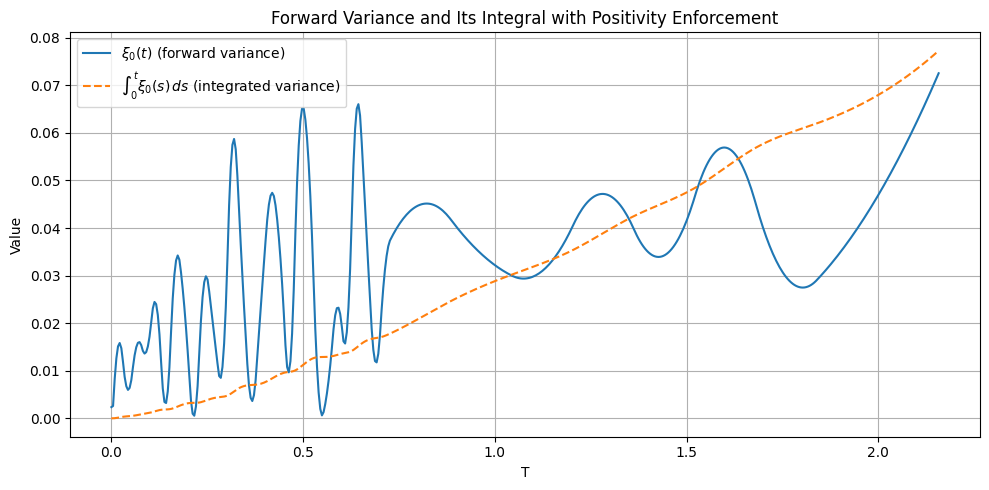

T = 0.50 | SSR mean = 0.7521 % | SSR std = 0.0000 % | SSR variance = 0.000000
          Skew mean = -0.4675 | Skew std = 0.0000
          Stickiness mean = -0.3516 | Stickiness std = 0.0000
T = 1.12 | SSR mean = 0.6464 % | SSR std = 0.0000 % | SSR variance = 0.000000
          Skew mean = -0.2726 | Skew std = 0.0000
          Stickiness mean = -0.1762 | Stickiness std = 0.0000
T = 1.75 | SSR mean = 0.6115 % | SSR std = 0.0000 % | SSR variance = 0.000000
          Skew mean = -0.1915 | Skew std = 0.0000
          Stickiness mean = -0.1171 | Stickiness std = 0.0000
T = 2.38 | SSR mean = 0.5792 % | SSR std = 0.0000 % | SSR variance = 0.000000
          Skew mean = -0.1558 | Skew std = 0.0000
          Stickiness mean = -0.0903 | Stickiness std = 0.0000
T = 3.00 | SSR mean = 0.5674 % | SSR std = 0.0000 % | SSR variance = 0.000000
          Skew mean = -0.1288 | Skew std = 0.0000
          Stickiness mean = -0.0731 | Stickiness std = 0.0000


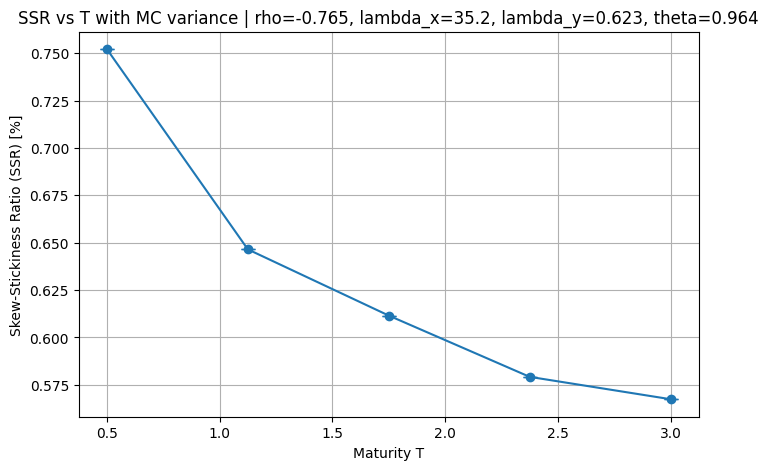

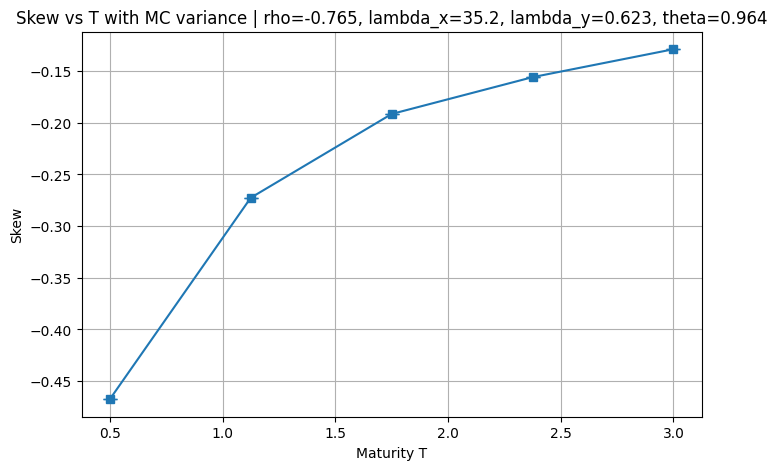

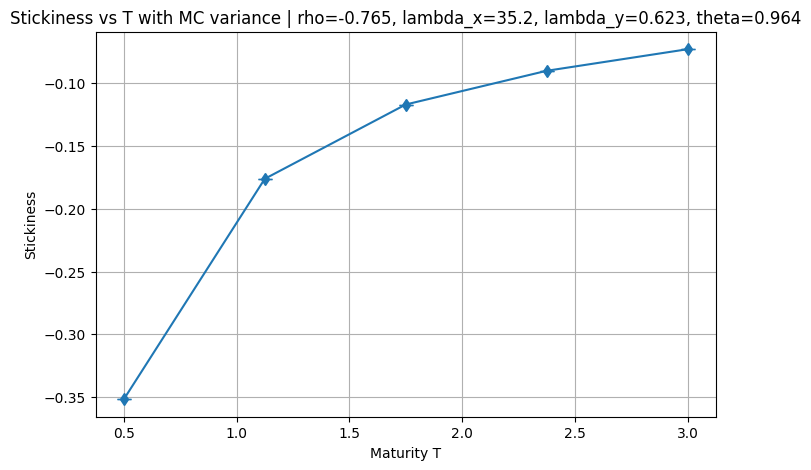

In [8]:
def compute_ssr(theta, rho, lambda_x, lambda_y, a_k, ksi_0, T, S0, n_steps, N_sims,Y_storage_shared,
             ssr_h=1e-5, h_skew=1e-5, epsilon=1e-6):
    


    strike_array = S0 * (np.exp([-h_skew, 0,h_skew]))
    model_skew = two_Quintic_OU(theta, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage_shared, S0)
    model_skew.sigma(ksi_0, x1=0, x2=0)
    model_skew.simulate_logS_batched()
    call_prices, _ = model_skew.price_call_conditional_mc(ksi_0, strike_array)
    imp_vols = vec_find_vol_rat(call_prices, S0, strike_array, T, flag='c', r=0)
    skew = (imp_vols[2] - imp_vols[0]) / (2 * h_skew)
    v0 = ksi_0(0)
    incr = ssr_h * rho / np.sqrt(v0)
    strike_atm = np.array([S0])
    model_base = two_Quintic_OU(theta, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage_shared, S0)
    model_base.sigma(ksi_0, x1=0, x2=0)
    model_base.simulate_logS_batched()
    call_base, _ = model_base.price_call_conditional_mc(ksi_0, strike_atm)
    iv_base = vec_find_vol_rat(call_base, S0, strike_atm, T, flag='c', r=0)

    model_incr = two_Quintic_OU(theta, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage_shared, S0)
    model_incr.sigma(ksi_0, x1=incr, x2=incr)
    model_incr.simulate_logS_batched()
    call_incr, _ = model_incr.price_call_conditional_mc(ksi_0, strike_atm)
    iv_incr = vec_find_vol_rat(call_incr, S0, strike_atm, T, flag='c', r=0)

    d_sigma_dx = (iv_incr - iv_base) / ssr_h

    if np.abs(skew) < epsilon:
        ssr_value = np.nan
    else:
        ssr_value = (d_sigma_dx / skew)[0]

    return ssr_value, skew, d_sigma_dx[0]

# ==== PARAMÈTRES ====
a_k = [0.0004, 0.0038, 0.0004, 0.0085, 0.0005,1]
n_steps = 6000
N_sims = 2000
lambda_x = 35.2
lambda_y = 0.623
S0 = 100
rho = -0.765
theta = 0.964

T_nodes = np.array([
    0.0001, 0.0005, 0.001 , 0.0015, 0.0055, 0.0303, 0.0552, 0.0801,
    0.105 , 0.1298, 0.1547, 0.1796, 0.2044, 0.2293, 0.2542, 0.2791,
    0.3039, 0.3288, 0.3537, 0.3785, 0.4034, 0.4283, 0.4531, 0.478 ,
    0.5029, 0.5278, 0.5526, 0.5775, 0.6024, 0.6272, 0.6521, 0.677 ,
    0.7019, 0.7267, 0.8857, 1.0447, 1.2036, 1.3626, 1.5216, 1.6805,
    1.8395, 1.9985, 2.1574
])

int_var_nodes = np.array([
    0.00000023, 0.00000117, 0.00000235, 0.00000352, 0.00001286,
    0.00033119, 0.00052188, 0.00088383, 0.00126912, 0.0017979 ,
    0.00196599, 0.00270324, 0.00322654, 0.00332477, 0.00396569,
    0.00442826, 0.0048271 , 0.00615094, 0.00692078, 0.00707639,
    0.0076925 , 0.00881826, 0.00963305, 0.01002174, 0.01142226,
    0.01267608, 0.012891  , 0.013082  , 0.01361588, 0.0141797 ,
    0.01568081, 0.01668033, 0.01704239, 0.01780291, 0.02466145,
    0.03022112, 0.03537132, 0.04249715, 0.04841705, 0.05687464,
    0.0619833 , 0.06789834, 0.07726454
])

#
# === Création de la spline cubique pour approximer la variance intégrée ===
spline_int_var = interpolate.splrep(T_nodes, int_var_nodes, k=3)

# === Fonction ksi_0 calculant la variance instantanée par dérivation avec positivité assurée ===
def ksi_0(t):
    deriv_values = interpolate.splev(t, spline_int_var, der=1)
    # Assure positivity:
    return np.sqrt(deriv_values ** 2)

# === Fonction pour calculer l'intégrale de ksi_0 ===
def integral_ksi_0(t):
    return interpolate.splev(t, spline_int_var, der=0)

# === Grille pour tracé ===
t_grid = np.linspace(T_nodes[0], T_nodes[-1], 500)
ksi_values = ksi_0(t_grid)
int_ksi_values = integral_ksi_0(t_grid)

# === Tracé ===
plt.figure(figsize=(10, 5))

plt.plot(t_grid, ksi_values, label=r'$\xi_0(t)$ (forward variance)')
plt.plot(t_grid, int_ksi_values, label=r'$\int_0^t \xi_0(s)\,ds$ (integrated variance)', linestyle='--')

plt.xlabel('T')
plt.ylabel('Value')
plt.title('Forward Variance and Its Integral with Positivity Enforcement')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# === Paramètres Monte Carlo SSR ===
T_grid = np.linspace(0.5, 3, 5)
N_mc = 2  # nombre de runs pour estimer la variance

SSR_means = []
SSR_stds = []
skew_means = []
skew_stds = []
stickiness_means = []
stickiness_stds = []
Y_storage_shared = np.random.normal(0, 1, (N_sims, n_steps))
Y_storage_shared[:,0] = 0
for T in T_grid:
    ssr_samples = []
    skew_samples = []
    stickiness_samples = []
    for i in range(N_mc):
        val, skew, stickiness = compute_ssr(
            theta, rho, lambda_x, lambda_y, a_k, ksi_0, T, S0, n_steps, N_sims, Y_storage_shared=Y_storage_shared

        )
        ssr_samples.append(val)  # en %
        skew_samples.append(skew)
        stickiness_samples.append(stickiness)

    # Convert to np.array for stats
    ssr_samples = np.array(ssr_samples)
    skew_samples = np.array(skew_samples)
    stickiness_samples = np.array(stickiness_samples)

    # Compute means and stds
    mean_ssr = np.mean(ssr_samples)
    std_ssr = np.std(ssr_samples, ddof=1)
    mean_skew = np.mean(skew_samples)
    std_skew = np.std(skew_samples, ddof=1)
    mean_stickiness = np.mean(stickiness_samples)
    std_stickiness = np.std(stickiness_samples, ddof=1)

    # Append to lists
    SSR_means.append(mean_ssr)
    SSR_stds.append(std_ssr)
    skew_means.append(mean_skew)
    skew_stds.append(std_skew)
    stickiness_means.append(mean_stickiness)
    stickiness_stds.append(std_stickiness)

    print(f"T = {T:.2f} | SSR mean = {mean_ssr:.4f} % | SSR std = {std_ssr:.4f} % | SSR variance = {std_ssr**2:.6f}")
    print(f"          Skew mean = {mean_skew:.4f} | Skew std = {std_skew:.4f}")
    print(f"          Stickiness mean = {mean_stickiness:.4f} | Stickiness std = {std_stickiness:.4f}")

# Convert to np.array for plotting
SSR_means = np.array(SSR_means)
SSR_stds = np.array(SSR_stds)
skew_means = np.array(skew_means)
skew_stds = np.array(skew_stds)
stickiness_means = np.array(stickiness_means)
stickiness_stds = np.array(stickiness_stds)

# === Plot SSR vs T with error bars ===
plt.figure(figsize=(8, 5))
plt.errorbar(T_grid, SSR_means, yerr=SSR_stds, fmt='o-', capsize=5)
plt.xlabel("Maturity T")
plt.ylabel("Skew-Stickiness Ratio (SSR) [%]")
plt.title(f"SSR vs T with MC variance | rho={rho}, lambda_x={lambda_x}, lambda_y={lambda_y}, theta={theta}")
plt.grid(True)

# === Plot Skew vs T with error bars ===
plt.figure(figsize=(8, 5))
plt.errorbar(T_grid, skew_means, yerr=skew_stds, fmt='s-', capsize=5)
plt.xlabel("Maturity T")
plt.ylabel("Skew")
plt.title(f"Skew vs T with MC variance | rho={rho}, lambda_x={lambda_x}, lambda_y={lambda_y}, theta={theta}")
plt.grid(True)

# === Plot Stickiness vs T with error bars ===
plt.figure(figsize=(8, 5))
plt.errorbar(T_grid, stickiness_means, yerr=stickiness_stds, fmt='d-', capsize=5)
plt.xlabel("Maturity T")
plt.ylabel("Stickiness")
plt.title(f"Stickiness vs T with MC variance | rho={rho}, lambda_x={lambda_x}, lambda_y={lambda_y}, theta={theta}")
plt.grid(True)

plt.show()


In [9]:
def moment_gaussian(k, sigma):
    """
    Compute E[Z^k] for Z ~ N(0, sigma^2)

    Parameters:
    - k: integer, the order of the moment
    - sigma: standard deviation of Z

    Returns:
    - E[Z^k]
    """
    if k % 2 == 1:
        return 0.0  # odd moments are zero for symmetric Gaussian
    else:
        # Even moment: sigma^k * (k - 1)!!
        return sigma**k * math.prod(range(1, k, 2)) if k > 0 else 1.0
    
def compute_sigma_matrix(lam_x, lam_y, t):
    def sigma_ij(lam_i, lam_j):
        return (1 - np.exp(-(lam_i + lam_j) * t)) / (lam_i + lam_j)
    
    sigma_xx = sigma_ij(lam_x, lam_x)
    sigma_yy = sigma_ij(lam_y, lam_y)
    sigma_xy = sigma_ij(lam_x, lam_y)  # same as sigma_yx

    Sigma = np.array([[sigma_xx, sigma_xy],
                      [sigma_xy, sigma_yy]])
    print("Sigma =\n", Sigma)

    # Ajoute ceci pour déboguer
    eigvals = np.linalg.eigvals(Sigma)
    print("Valeurs propres :", eigvals)
    return Sigma

def vec_find_iv_rat(opt_price, S, K, t, r, flag):
    return np.vectorize(implied_volatility)(opt_price, S, K, t, r, flag)

# === Helper functions ===
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

def moment_gaussian(degree, sigma):
    if degree % 2 == 0:
        return sigma ** degree * factorial2(degree - 1)
    else:
        return 0.0

def compute_sigma_matrix(lambda_x, lambda_y, T):
    var_X = (1 - np.exp(-2 * lambda_x * T)) / (2 * lambda_x)
    var_Y = (1 - np.exp(-2 * lambda_y * T)) / (2 * lambda_y)
    cov_XY = (1 - np.exp(-(lambda_x + lambda_y) * T)) / (lambda_x + lambda_y)
    return np.array([[var_X, cov_XY], [cov_XY, var_Y]])

def h_2(x, y, beta, delta, n):
    result = 0.0
    for m in range(n):
        for l in range(m, n):
            result += beta[m, l] * x ** m * y ** (l - m)
    return result / delta

# === Quantization data ===
# Note: Le chemin du fichier doit être adapté selon votre environnement
try:
    data = np.loadtxt("/home/hassene/Desktop/Stage_code/mult_dimensional_grids/1450_2_nopti")
    points = data[:-1, 1:3]
    weights = data[:-1, 0]
except FileNotFoundError:
    # Données par défaut si le fichier n'est pas trouvé
    print("Fichier de quantification non trouvé, utilisation de données par défaut")
    points = np.random.randn(100, 2)
    weights = np.ones(100) / 100

def gaussian_expectation(f, mu, Sigma, points=points, weights=weights):
    A = np.linalg.cholesky(Sigma+1e-5*np.eye(2))
    transformed_points = points @ A.T + mu
    f_vals = np.array([f(x, y) for x, y in transformed_points])
    return np.sum(f_vals * weights)





In [10]:

# === Main class ===
class vix_two_Quintic():
    def __init__(self, theta, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage, delta):
        self.theta = theta
        self.rho = rho
        self.a_k = a_k
        self.lambda_x = lambda_x
        self.lambda_y = lambda_y
        self.N_sims = N_sims
        self.n_steps = n_steps
        self.T = T
        self.delta = delta
        self.Y_storage = Y_storage
        self.beta = None
        self.Z = None
        self.X1 = None
        self.X2 = None
        self.tt_gs = None
        self.w_t_gs = None
        self.vix_T_squared = None

    def simulate_ou(self, x1, x2):
        dt = (self.T + self.delta) / self.n_steps
        X1 = np.zeros((self.N_sims, self.n_steps + 1))
        X2 = np.zeros((self.N_sims, self.n_steps + 1))
        exp1 = np.exp(-self.lambda_x * dt)
        exp2 = np.exp(-self.lambda_y * dt)
        var1 = np.sqrt((1 - np.exp(-2 * self.lambda_x * dt)) / (2 * self.lambda_x))
        var2 = np.sqrt((1 - np.exp(-2 * self.lambda_y * dt)) / (2 * self.lambda_y))
        X1[:, 0] = x1
        X2[:, 0] = x2
        for i in range(self.n_steps):
            X1[:, i + 1] = exp1 * X1[:, i] + var1 * self.Y_storage[:, i]
            X2[:, i + 1] = exp2 * X2[:, i] + var2 * self.Y_storage[:, i]
        self.X1 = X1
        self.X2 = X2
        return X1, X2

    def simulate_OU(self, x1=0, x2=0):
        self.simulate_ou(x1, x2)
        self.Z = self.theta * self.X1 + (1 - self.theta) * self.X2
        return self.Z

    def sigma_G_squared(self, s_array):
        delta = self.T + self.delta - s_array
        term1 = (self.theta ** 2) / (2 * self.lambda_x) * (1 - np.exp(-2 * self.lambda_x * delta))
        term2 = ((1 - self.theta) ** 2) / (2 * self.lambda_y) * (1 - np.exp(-2 * self.lambda_y * delta))
        term3 = (2 * self.theta * (1 - self.theta)) / (self.lambda_x + self.lambda_y) * (1 - np.exp(-(self.lambda_x + self.lambda_y) * delta))
        return term1 + term2 + term3

    def co_var_func(self, theta, lambda_x, lambda_y, t, show_covar=False):
        var_1 = (1 - np.exp(-2 * lambda_x * t)) / (2 * lambda_x)
        var_2 = (1 - np.exp(-2 * lambda_y * t)) / (2 * lambda_y)
        covar = (1 - np.exp(-(lambda_x + lambda_y) * t)) / (lambda_x + lambda_y)
        var = theta**2 * var_1 + (1 - theta)**2 * var_2 + 2 * theta * (1 - theta) * covar

        if show_covar == False:
            return var
        else:
            return covar

    def compute_quadrature(self, n_t=100):
        """
        The number of quadrature points used to compute the integral in time
        """
        return np.polynomial.legendre.leggauss(n_t + 1)

    def gaussian_moments(self, sigma, degree):
        """Calcule les moments gaussiens"""
        if degree % 2 == 0:
            if degree == 0:
                return np.ones_like(sigma)
            else:
                return sigma ** degree * factorial2(degree - 1)
        else:
            return np.zeros_like(sigma)

    def compute_cauchy_product(self, a_k):
        """Compute the Cauchy product of polynomial coefficients"""
        return np.convolve(a_k, a_k)

    def compute_beta_vector_full_mc(self, ksi_0):
        self.tt_gs, self.w_t_gs = self.compute_quadrature()
        
        T_delta = self.T + self.delta
        w_tt = self.w_t_gs / 2 * (T_delta - self.T)
        tt = 0.5 * (self.tt_gs + 1) * (T_delta - self.T) + self.T
        tt = np.linspace(self.T,self.T+self.delta,self.n_steps)
        w_tt = self.delta/self.n_steps
        n = len(self.a_k)
        FV = ksi_0(tt)
        
        Z = self.simulate_OU()
        
        # Calcul des variances et covariances - using vectorized approach
        std_Z_t = np.sqrt(self.co_var_func(self.theta, self.lambda_x, self.lambda_y, tt))
        
        # Calcul du produit de Cauchy - using correct convolution
        cauchy_product = self.compute_cauchy_product(self.a_k)
        
        # Calcul de la constante de normalisation - corrected vectorized version
        normal_cst = np.sum(
            cauchy_product[np.arange(0, 2*n, 2)].reshape(-1, 1) * 
            std_Z_t**(np.arange(0, 2*n, 2).reshape(-1, 1)) * 
            np.maximum(scipy.special.factorial2(np.arange(0, 2*n, 2).reshape(-1, 1) - 1), 1), 
            axis=0
        )
        
        g_0_s_squared = FV / normal_cst
        std_G_s_t = np.sqrt(self.co_var_func(self.theta, self.lambda_x, self.lambda_y, tt - self.T))
        
        # Initialize beta matrix
        beta_m_l = np.zeros((2*n-1, 2*n-1))
        combinatory_matrix = scipy.special.comb(np.arange(2*n-1), np.arange(2*n-1).reshape(-1, 1))
        
        # Calcul des moments gaussiens - using list comprehension approach
        mmt_G_s_t = np.array([self.gaussian_moments(std_G_s_t, deg) for deg in np.arange(2*n-1)])

        # Variables pour le calcul de VIX
        var_X_t = self.co_var_func(1, self.lambda_x, self.lambda_y, self.T)
        var_Y_t = self.co_var_func(0.0, self.lambda_x, self.lambda_y, self.T)
        covar_XY_t = self.co_var_func(0.5, self.lambda_x, self.lambda_y, self.T, True)
        corr_XY_t = covar_XY_t / np.sqrt(var_X_t * var_Y_t)
        
        # Génération des variables aléatoires corrélées - corrected shape handling
        Z_mc = np.random.normal(0, 1, (2, self.N_sims))
        X = Z_mc[0:1].T * np.sqrt(var_X_t)
        Y = (corr_XY_t * Z_mc[0:1].T + np.sqrt(1 - corr_XY_t**2) * Z_mc[1:2].T) * np.sqrt(var_Y_t)
        
        # Calcul des puissances - corrected indexing
        X_power = X**np.arange(0, 2*n-1)[np.newaxis]
        Y_power = Y**np.arange(0, 2*n-1)[np.newaxis]
        l_array = np.arange(0, 2*n-1)

        # CORRECTED: Separate beta calculation from VIX computation
        for m in range(0, 2*n-1):
            for l in range(m, 2*n-1):
                integrand_2 = np.exp(-(m * self.lambda_x + (l-m) * self.lambda_y) * (tt - self.T))
                
                # Corrected integral calculation using vectorized approach
                k_array = np.arange(l, 2*n-1)
                integral = np.sum((mmt_G_s_t[k_array-l] * integrand_2 * g_0_s_squared) * w_tt, axis=1)
                
                # Corrected beta calculation with proper combinatorial matrix usage
                beta_m_l[m, l] = (np.sum(cauchy_product[k_array] * integral * combinatory_matrix[l, l:]) *
                                combinatory_matrix[m, l] * (1-self.theta)**(l-m) * self.theta**m)
        
        # CORRECTED: VIX calculation outside the beta loops
        vix_T_squared = np.zeros(self.N_sims)
        for m in range(0, 2*n-1):
            # Vectorized computation for each m
            vix_T_squared += np.sum(
                X_power[:, m:m+1] * Y_power[:, l_array[m:]-m] * beta_m_l[m, l_array[m:]], 
                axis=1
            )
        
        self.beta = beta_m_l
        self.vix_T_squared = vix_T_squared
        return self.beta

    def impl_vol_mc(self, ksi_0):
        if (self.beta is None):
            self.compute_beta_vector_full_mc(ksi_0=ksi_0)
        vix_T_squared = self.vix_T_squared
        vix_T_squared = vix_T_squared / self.delta
        if (vix_T_squared.any()<0):
            print("vix_T<0")
        vix_T = np.sqrt(np.maximum(vix_T_squared, 0))  # Éviter les racines négatives
        print("vix T shape is ", vix_T.shape)
        Ft = np.mean(vix_T)
        
        # Calcul des options VIX
        lm_vix = np.linspace(-0.1, 0.7, 40)
        strike_perc_vix = np.exp(lm_vix)
        vix_strike = strike_perc_vix * Ft
        vix_call_payoff = np.maximum(vix_T[:, np.newaxis] - vix_strike, 0)
        vix_opt = np.mean(vix_call_payoff, axis=0)
        vix_opt_std = np.std(vix_call_payoff, axis=0)
        vix_iv = vec_find_iv_rat(vix_opt, Ft, vix_strike, self.T, 0.0, 'c')
                
        return Ft * 100, vix_opt * 100, vix_opt_std * 100, vix_iv, vix_strike*100

    def impl_vol_quantization(self, ksi_0):
        
        # Ensure beta vector is computed
        if self.beta is None:
            self.compute_beta_vector_full_mc(ksi_0=ksi_0)
        
        # Define function for future VIX calculation
        def h_future(x, y):
            return np.sqrt(h_2(x, y, self.beta, self.delta, len(self.a_k)))
        
        mu = np.array([0.0, 0.0])
        sigma_matrix = compute_sigma_matrix(self.lambda_x, self.lambda_y, self.T)
        print("Sigma matrix is ",sigma_matrix)
        sigma_matrix+=1e-5*np.eye(2)
        A = np.linalg.cholesky(sigma_matrix)  

        # Compute expected future VIX level
        vix_future = gaussian_expectation(h_future, mu, Sigma=sigma_matrix)
        
        # Generate strike grid (log-moneyness)
        lm_vix = np.linspace(-0.1, 0.7, 40)
        strike_multipliers = np.exp(lm_vix)
        vix_strikes = strike_multipliers * vix_future
        
        # Compute option prices for each strike
        vix_prices = []
        for K in vix_strikes:
            def payoff_function(x, y):
                """Call option payoff: max(S - K, 0)"""
                underlying_value = np.sqrt(h_2(x, y, self.beta, self.delta, len(self.a_k)))
                return np.maximum(underlying_value - K, 0.0)
            
            option_price = gaussian_expectation(payoff_function, mu, Sigma=sigma_matrix)
            vix_prices.append(option_price)
        
        vix_prices = np.array(vix_prices)
        
        try:
            vix_iv = vec_find_iv_rat(
                vix_prices, 
                np.full_like(vix_prices, vix_future),  # Use future VIX as spot
                vix_strikes, 
                self.T, 
                r=0.0, 
                flag='c'
            )
        except Exception as e:
            print(f"Warning: IV calculation failed: {e}")
            # Return NaN array if IV calculation fails
            vix_iv = np.full_like(vix_prices, np.nan)
        
        return vix_future*100, vix_prices*100, 100*np.std(vix_prices), vix_iv, vix_strikes*100

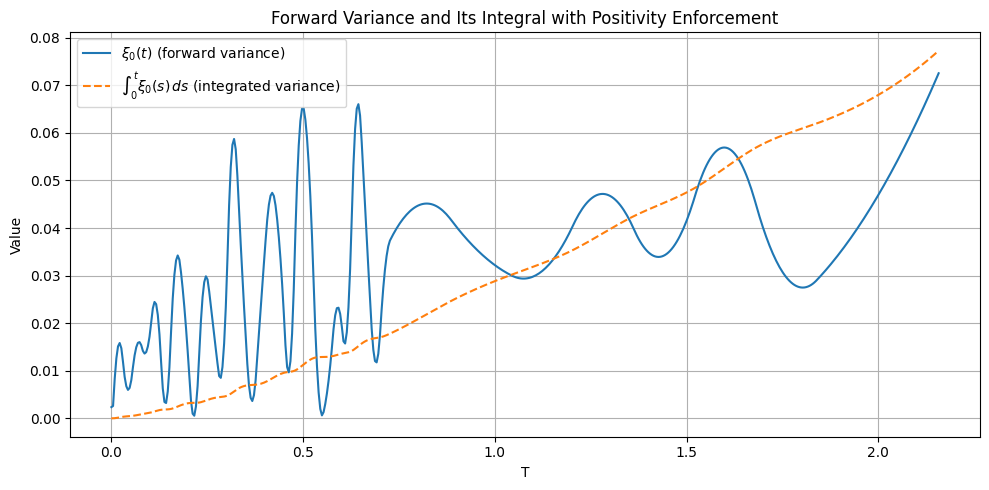

vix T shape is  (80000,)
Forward VIX: 10.9467
VIX Options prices (first 5): [1.16455365 1.05632517 0.96118321 0.87675031 0.80122346]
Model executed successfully!
beta is  [[7.83786477e-04 2.22768125e-04 5.64668819e-04 1.61406501e-05
  6.98831527e-05 5.11366188e-07 2.95040792e-06 2.00449388e-09
  4.87234344e-08 5.80381305e-12 3.41166761e-10]
 [0.00000000e+00 1.13959746e-03 3.49265688e-03 2.09624463e-04
  8.97751541e-04 1.58383245e-05 6.67730252e-05 8.63526495e-08
  1.79038218e-06 3.72144347e-10 2.45837771e-08]
 [0.00000000e+00 0.00000000e+00 9.40943043e-03 1.59469851e-03
  7.29583534e-03 3.19929280e-04 1.09849701e-03 2.58941575e-06
  4.89906437e-05 1.61032371e-08 1.20184374e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.41130465e-03
  3.85629016e-02 3.88330206e-03 1.35622190e-02 5.19465942e-05
  9.99276351e-04 4.70302596e-07 4.01752670e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.42117593e-02 2.53054893e-02 1.11128664e-01 6.72632159e-04
  1.43069890e-02 

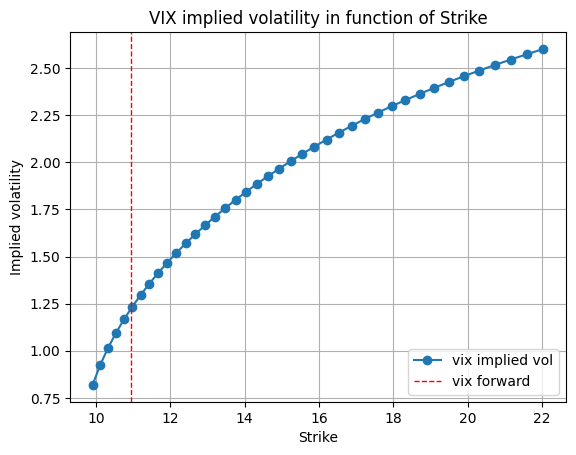

In [11]:

T_nodes = np.array([
    0.0001, 0.0005, 0.001 , 0.0015, 0.0055, 0.0303, 0.0552, 0.0801,
    0.105 , 0.1298, 0.1547, 0.1796, 0.2044, 0.2293, 0.2542, 0.2791,
    0.3039, 0.3288, 0.3537, 0.3785, 0.4034, 0.4283, 0.4531, 0.478 ,
    0.5029, 0.5278, 0.5526, 0.5775, 0.6024, 0.6272, 0.6521, 0.677 ,
    0.7019, 0.7267, 0.8857, 1.0447, 1.2036, 1.3626, 1.5216, 1.6805,
    1.8395, 1.9985, 2.1574
])

int_var_nodes = np.array([
    0.00000023, 0.00000117, 0.00000235, 0.00000352, 0.00001286,
    0.00033119, 0.00052188, 0.00088383, 0.00126912, 0.0017979 ,
    0.00196599, 0.00270324, 0.00322654, 0.00332477, 0.00396569,
    0.00442826, 0.0048271 , 0.00615094, 0.00692078, 0.00707639,
    0.0076925 , 0.00881826, 0.00963305, 0.01002174, 0.01142226,
    0.01267608, 0.012891  , 0.013082  , 0.01361588, 0.0141797 ,
    0.01568081, 0.01668033, 0.01704239, 0.01780291, 0.02466145,
    0.03022112, 0.03537132, 0.04249715, 0.04841705, 0.05687464,
    0.0619833 , 0.06789834, 0.07726454
])

#
# === Création de la spline cubique pour approximer la variance intégrée ===
spline_int_var = interpolate.splrep(T_nodes, int_var_nodes, k=3)

# === Fonction ksi_0 calculant la variance instantanée par dérivation avec positivité assurée ===
def ksi_0(t):
    deriv_values = interpolate.splev(t, spline_int_var, der=1)
    # Assure positivity:
    return np.sqrt(deriv_values ** 2)

# === Fonction pour calculer l'intégrale de ksi_0 ===
def integral_ksi_0(t):
    return interpolate.splev(t, spline_int_var, der=0)

# === Grille pour tracé ===
t_grid = np.linspace(T_nodes[0], T_nodes[-1], 500)
ksi_values = ksi_0(t_grid)
int_ksi_values = integral_ksi_0(t_grid)

# === Tracé ===
plt.figure(figsize=(10, 5))

plt.plot(t_grid, ksi_values, label=r'$\xi_0(t)$ (forward variance)')
plt.plot(t_grid, int_ksi_values, label=r'$\int_0^t \xi_0(s)\,ds$ (integrated variance)', linestyle='--')

plt.xlabel('T')
plt.ylabel('Value')
plt.title('Forward Variance and Its Integral with Positivity Enforcement')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


a_k = np.array([0.0004, 0.0038, 0.0004, 0.0085, 0.0005, 1])
T = 1/52
n_steps = 100
N_sims = 80000
lambda_x = 35.2
lambda_y = 0.623
rho = -0.769
tetha = 0.94
Y_storage = np.random.normal(0, 1, (N_sims, n_steps))


model = vix_two_Quintic(
        theta=0.94,
        rho=-0.769,
        lambda_x=35.2,
        lambda_y=0.623,
        N_sims=N_sims,
        n_steps=n_steps,
        a_k=a_k,
        T=1/52,
        Y_storage=Y_storage,
        delta=30/360
    )
    
results = model.impl_vol_mc(ksi_0)
Ft, vix_opt, vix_opt_std = results[:3]
print(f"Forward VIX: {Ft:.4f}")
print(f"VIX Options prices (first 5): {vix_opt[:5]}")
print("Model executed successfully!")
print("beta is ",model.beta)
vix,strike_array = results[3],results[4]
print("vix strike is ", strike_array)
print("vix opt is ", vix_opt)
print("vix opt std is ", vix_opt_std)   

plt.plot(strike_array,vix,marker='o',label="vix implied vol")
plt.axvline(x=Ft,color='r',label="vix forward",linestyle='--',linewidth=1)
plt.grid()
plt.legend()
plt.xlabel("Strike")
plt.ylabel("Implied volatility")
plt.title("VIX implied volatility in function of Strike")

plt.show()
        
